## Binance top 200 coins by volume and momentum

In [50]:
coins = 400

## 1- Obtengo la data usando la API de Binance

In [58]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def get_top_volume_coins_list_api(count=200):
    # Obtener la lista de todos los símbolos de trading
    symbols_url = "https://api.binance.com/api/v3/exchangeInfo"
    symbols_response = requests.get(symbols_url)
    symbols_data = symbols_response.json()
    
    # Filtrar solo los pares con USDT
    usdt_symbols = [symbol['symbol'] for symbol in symbols_data['symbols'] if symbol['symbol'].endswith('USDT')]

    # Elimino las stablecoins
    stablecoins = ['USDCUSDT', 'FDUSDUSDT', '1000SATS', '1000SATSBTC', 'WBTC','WBTCUSDT', 'WETHUSDT']
    usdt_symbols = [symbol for symbol in usdt_symbols if symbol not in stablecoins]
    
    # Calcular la fecha de inicio (7 días atrás)
    start_time = int((datetime.now() - timedelta(days=7)).timestamp() * 1000)
    
    # Obtener el volumen para cada símbolo
    volumes = []
    for symbol in usdt_symbols:
        klines_url = f"https://api.binance.com/api/v3/klines?symbol={symbol}&interval=1d&startTime={start_time}"
        klines_response = requests.get(klines_url)
        klines_data = klines_response.json()
        
        # Calcular el volumen promedio
        total_volume = sum(float(kline[7]) for kline in klines_data) #7 es quote asset volume
        avg_volume = total_volume / len(klines_data) if klines_data else 0
        volumes.append((symbol[:-4], avg_volume))  # Removemos 'USDT' del símbolo
    
    # Ordenar por volumen descendente y tomar los primeros 'count'
    top_volumes = sorted(volumes, key=lambda x: x[1], reverse=True)[:count]
    
    return top_volumes  # Ahora retornamos la lista completa de tuplas (moneda, volumen)

def get_top_volume_coins_df_api(count=200):
    volumes = get_top_volume_coins_list_api(count)
    df = pd.DataFrame(volumes, columns=['coin', 'average volume last 7 days'])

    # Ordenar el DataFrame antes de formatear los números
    df = df.sort_values('average volume last 7 days', ascending=False)

   # Formatear los números después de ordenar
    df['average volume last 7 days'] = df['average volume last 7 days'].apply(lambda x: f'{x:.2f}')

    return df

In [63]:
# Esta lista de tuplas con los volumenes se guarda en la BD
api_top_coins_list = get_top_volume_coins_list_api(coins)
api_top_coins_list

[('BTC', 1313439449.981425),
 ('ETH', 617015140.7221014),
 ('SOL', 405158346.9422371),
 ('NEIRO', 311974720.8399772),
 ('CATI', 195047694.29614002),
 ('SUI', 175032369.56174996),
 ('PEPE', 162992993.9616581),
 ('BNB', 132381254.67541428),
 ('WIF', 105628644.39367428),
 ('XRP', 91512182.9364857),
 ('FET', 84074249.28844287),
 ('TAO', 71722942.60174285),
 ('DOGS', 67693296.75128517),
 ('NEAR', 64695087.10798572),
 ('FTM', 58471056.424),
 ('DOGE', 54949819.93630713),
 ('1000SATS', 54178030.077866),
 ('TIA', 52046648.756531425),
 ('SAGA', 51194169.569314286),
 ('AVAX', 49266666.94200001),
 ('SEI', 46964531.572195716),
 ('1MBABYDOGE', 42806701.71108217),
 ('ORDI', 38979042.9708),
 ('BOME', 38768453.458356716),
 ('PENDLE', 37418912.65855714),
 ('AAVE', 33915571.863262855),
 ('ARB', 33682900.57651857),
 ('CKB', 33408345.521793287),
 ('WLD', 33106488.16848572),
 ('ZRO', 33054810.495034285),
 ('FIDA', 31878917.891145714),
 ('FLOKI', 31667303.427571334),
 ('RUNE', 31597807.765142854),
 ('APT', 3

In [25]:
#api_top_coins_df = get_top_volume_coins_df_api(coins)
#api_top_coins_df

#### Conclusion

Las variables que pasan a la siguiente etapa son: 


api_top_coins_df 

api_top_coins_list

Trabajare con la lista pero primero tengo que eliminar los valores de volumen, que hago a continuacion

In [67]:
# Get the ticker list for coins. sin el volumen,
top_coins = [item[0] for item in api_top_coins_list]
#top_coins

Uso la lista manual que estoy manejando en django

In [61]:
import os

# Obtener el directorio actual
path_actual = os.getcwd()

# Construir la ruta al archivo en la carpeta 'crypto_portfolio'
ruta_archivo = os.path.join(path_actual, 'crypto_portfolio', 'nombre_del_archivo.py')

print("Ruta del archivo:", ruta_archivo)

Ruta del archivo: /Users/egrados/Library/CloudStorage/OneDrive-Personal/Github/CS50-web-programming/5-capstone/crypto_portfolio/nombre_del_archivo.py


In [66]:
from crypto_portfolio.database import tickers_list


## 2- Obtener klines para cada criptomoeda

#### USANDO EL WRAPER

In [30]:
# Obtiene klines con la lista top_coins, el par BTC y el par USDT
# FUNCION QUE USA EL WRAPER
import pandas as pd
from binance.client import Client
from datetime import datetime, timedelta, timezone
import os


client = Client()

not_available_btcpair = []
# FUNCION PARA BTC PAIRS
def get_klines_btcpair_wraper(crypto_list, weeks_back: int):
    """    
    weeks_back: int -> Indica la cantidad de semanas atras a considerar. 0 para esta semana, 1 para la semana anterior, etc.
    """
    today = datetime.now(timezone.utc)  # Asegurarse de trabajar en UTC
    
    # Calcular el lunes de la semana actual
    monday_this_week = today - timedelta(days=today.weekday())

    # Obtener la fecha del lunes de la semana objetivo y convertir a 00:00 en UTC
    target_monday = monday_this_week - timedelta(weeks=weeks_back)
    target_monday_at_midnight = target_monday.replace(hour=0, minute=0, second=0, microsecond=0)

    # Obtener la fecha del domingo de la semana objetivo y convertir a 00:00 en UTC
    target_sunday = target_monday + timedelta(days=6)
    target_sunday_at_midnight = target_sunday.replace(hour=0, minute=0, second=0, microsecond=0)    

    # Retornar como timestamp en UTC en str
    start_timestamp = str(target_monday_at_midnight.timestamp())
    print(f"Start timestamp: {start_timestamp}")

    end_timestamp = str(target_sunday_at_midnight.timestamp())
    print(f"End timestamp: {end_timestamp}")


    dataframes = []

    # Crear la carpeta 'data' si no existe
    if not os.path.exists('data'):
        os.makedirs('data')

    for crypto in crypto_list:
        try:
            print(f"Fetching data for {crypto}BTC...")
            klines = client.get_historical_klines(
                symbol=f"{crypto}BTC", # for BTC pairs
                #symbol=f"{crypto}USDT", # for USDT pairs
                interval=Client.KLINE_INTERVAL_1DAY,
                start_str=start_timestamp,
                end_str=end_timestamp,
            )
            print (klines)

            # Crear el DataFrame
            df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
            
            # Convertir el timestamp a datetime
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            
            # Establecer el timestamp como índice
            df.set_index('timestamp', inplace=True)
            
            # Convertir las columnas necesarias a float
            for col in ['open', 'high', 'low', 'close', 'volume']:
                df[col] = df[col].astype(float)
            
            # Guardar el DataFrame como CSV
            filename = f"data/{crypto}BTC.csv"
            df.to_csv(filename)
            
            dataframes.append(df)
            print(f"Datos de {crypto} guardados en {filename}")

        except Exception as e:
            print(f"Error al obtener datos para {crypto}BTC.")
            print(e)
            not_available_btcpair.append(crypto)
            continue

    return dataframes

#ejemplo de uso
#dataframes = get_klines_btcpair_wraper(top_coins, 1)

#### USANDO LA API PELADA

In [72]:
# Obtiene klines con la lista top_coins, el par BTC y el par USDT
import pandas as pd
from binance.client import Client
from datetime import datetime, timedelta, timezone
import os


not_available_btcpair = []
# FUNCION PARA BTC PAIRS
def get_klines_btcpair(crypto_list, weeks_back: int):
    """    
    weeks_back: int -> Indica la cantidad de semanas atras a considerar. 0 para esta semana, 1 para la semana anterior, etc.
    """
    today = datetime.now(timezone.utc)  # Asegurarse de trabajar en UTC
    
    # Calcular el lunes de la semana actual
    monday_this_week = today - timedelta(days=today.weekday())

    # Obtener la fecha del lunes de la semana objetivo y convertir a 00:00 en UTC
    target_monday = monday_this_week - timedelta(weeks=weeks_back)
    target_monday_at_midnight = target_monday.replace(hour=0, minute=0, second=0, microsecond=0)

    # Obtener la fecha del domingo de la semana objetivo y convertir a 00:00 en UTC
    target_sunday = target_monday + timedelta(days=6)
    target_sunday_at_midnight = target_sunday.replace(hour=0, minute=0, second=0, microsecond=0)    

    # Retornar como timestamp en UTC en str
    start_timestamp = str(int(target_monday_at_midnight.timestamp()))
    print(f"Start timestamp: {start_timestamp}")

    end_timestamp = str(int(target_sunday_at_midnight.timestamp()))
    print(f"End timestamp: {end_timestamp}")


    dataframes = []

    # Crear la carpeta 'data' si no existe
    if not os.path.exists('data'):
        os.makedirs('data')

    for crypto in crypto_list:
        
        print(f"Fetching data for {crypto}BTC...")
        symbol=f"{crypto}BTC" # for BTC pairs
        start_str=start_timestamp+'000'
        #print(start_str)
        end_str=end_timestamp+'000'

        klines_url = f"https://api.binance.com/api/v3/klines?symbol={symbol}&interval=1d&startTime={start_str}&endTime={end_str}"
        klines_response = requests.get(klines_url)

        if klines_response.status_code == 200:
            print('se obtuvo codigo 200 para {crypto}')
            klines_data = klines_response.json()
            if len(klines_data) == 0:
                print(f"No data available for {crypto}BTC")
                not_available_btcpair.append(crypto)
                continue

            # Crear el DataFrame
            df = pd.DataFrame(klines_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
            
            # Convertir el timestamp a datetime
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            
            # Establecer el timestamp como índice
            df.set_index('timestamp', inplace=True)
            
            # Convertir las columnas necesarias a float
            for col in ['open', 'high', 'low', 'close', 'volume']:
                df[col] = df[col].astype(float)
            
            # Eliminar las columnas que no me sirve
            df = df.drop(['close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], axis=1)

            # Guardar el DataFrame como CSV
            filename = f"data/{crypto}BTC.csv"
            df.to_csv(filename)
            
            dataframes.append(df)
            print(f"Datos de {crypto} guardados en {filename}")
            print ('-----------------------------------------')
        
        elif klines_response.status_code == 404:
            print(f"Error: {crypto}BTC no está disponible en Binance.")
            print(klines_response.text)
            not_available_btcpair.append(crypto)
            print ('-----------------------------------------')

        elif klines_response.status_code == 400:
            print(f"Error: {crypto}BTC no está disponible en Binance.")
            not_available_btcpair.append(crypto)
            print ('-----------------------------------------')

    return dataframes

#ejemplo de uso
#dataframes = get_klines_btcpair(top_coins, 1) #llamo al de la semana pasada

In [ ]:
#this_week_gainers = get_klines_btcpair(top_coins, 1) #semana pasada, rebalnce actual
#past_week_gainers = get_klines_btcpair(top_coins, 2) #dos semanas atras, rebalnce anterior


#### Nueva version que guarda los datos de dos semanas PASADA Y ACTUAL, tanto en CSV como en BD


In [87]:
# Obtiene klines con la lista top_coins, el par BTC y el par USDT de las ultimas 2 semanas

import pandas as pd
from datetime import datetime, timedelta, timezone
import os
import requests

not_available_btcpair = []

def get_klines_btcpair_past2weeks(crypto_list):
    today = datetime.now(timezone.utc)
    
    # Calcular el lunes de la semana actual
    monday_this_week = today - timedelta(days=today.weekday())
    
    # Calcular el lunes de hace dos semanas (inicio del período)
    start_monday = monday_this_week - timedelta(weeks=2)
    start_monday_at_midnight = start_monday.replace(hour=0, minute=0, second=0, microsecond=0)
    
    # Calcular el domingo de la semana pasada (fin del período)
    end_sunday = monday_this_week - timedelta(days=1)
    end_sunday_at_midnight = end_sunday.replace(hour=23, minute=59, second=59, microsecond=999999)

    # Convertir a timestamp en UTC
    start_timestamp = str(int(start_monday_at_midnight.timestamp() * 1000))
    end_timestamp = str(int(end_sunday_at_midnight.timestamp() * 1000))

    print(f"Periodo de obtención de datos: {start_monday_at_midnight} a {end_sunday_at_midnight}")

    dataframes = []

    # Crear la carpeta 'data' si no existe
    if not os.path.exists('data_past2weeks'):
        os.makedirs('data_past2weeks')

    for crypto in crypto_list:
        print(f"Obteniendo datos para {crypto}BTC...")
        symbol = f"{crypto}BTC"

        klines_url = f"https://api.binance.com/api/v3/klines?symbol={symbol}&interval=1d&startTime={start_timestamp}&endTime={end_timestamp}"
        klines_response = requests.get(klines_url)

        if klines_response.status_code == 200:
            klines_data = klines_response.json()
            if len(klines_data) == 0:
                print(f"No hay datos disponibles para {crypto}BTC")
                not_available_btcpair.append(crypto)
                continue

            # Crear el DataFrame
            df = pd.DataFrame(klines_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
            
            # Convertir el timestamp a datetime
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            
            # Establecer el timestamp como índice
            df.set_index('timestamp', inplace=True)
            
            # Convertir las columnas necesarias a float
            for col in ['open', 'high', 'low', 'close', 'volume']:
                df[col] = df[col].astype(float)
            
            # Eliminar las columnas que no necesitamos
            df = df.drop(['close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], axis=1)

            # Guardar el DataFrame como CSV
            filename = f"data_past2weeks/{crypto}BTC.csv"
            df.to_csv(filename)
            
            dataframes.append(df)
            print(f"Datos de {crypto}BTC guardados en {filename}")
            print('-' * 50)
        
        elif klines_response.status_code in [404, 400]:
            print(f"Error: {crypto}BTC no está disponible en Binance.")
            not_available_btcpair.append(crypto)
            print('-' * 50)

    return dataframes

In [86]:
past_2week_gainers = get_klines_btcpair_past2weeks(top_coins) #dos semanas atras, rebalnce anterior


Periodo de obtención de datos: 2024-09-09 00:00:00+00:00 a 2024-09-22 23:59:59.999999+00:00
Obteniendo datos para BTCBTC...
Error: BTCBTC no está disponible en Binance.
--------------------------------------------------
Obteniendo datos para ETHBTC...
Datos de ETHBTC guardados en data_2/ETHBTC.csv
--------------------------------------------------
Obteniendo datos para SOLBTC...
Datos de SOLBTC guardados en data_2/SOLBTC.csv
--------------------------------------------------
Obteniendo datos para NEIROBTC...
Error: NEIROBTC no está disponible en Binance.
--------------------------------------------------
Obteniendo datos para CATIBTC...
Error: CATIBTC no está disponible en Binance.
--------------------------------------------------
Obteniendo datos para SUIBTC...
Datos de SUIBTC guardados en data_2/SUIBTC.csv
--------------------------------------------------
Obteniendo datos para PEPEBTC...
Error: PEPEBTC no está disponible en Binance.
-------------------------------------------------

## 3. Data Analysis

In [33]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def analyze_crypto_data(data_folder='data'):
    results = []
    
    for filename in os.listdir(data_folder):
        if filename.endswith('.csv'):
            coin = filename.split('.')[0]
            filepath = os.path.join(data_folder, filename)
            
            # Leer el archivo CSV
            df = pd.read_csv(filepath)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            
            # Calcular el retorno
            first_open = df.iloc[0]['open']
            last_close = df.iloc[-1]['close']
            returns = (last_close - first_open) / first_open * 100
            
            # Preparar datos para la regresión lineal
            X = np.arange(len(df)).reshape(-1, 1)
            y = df['close'].values
            
            # Realizar regresión lineal
            model = LinearRegression()
            model.fit(X, y)
            
            intercept = model.intercept_
            slope = model.coef_[0]
            
            results.append({
                'coin': coin,
                'return': returns,
                'intercept': intercept,
                'slope': slope
            })
            print(f"Análisis para {coin} completado.")
    
    # Crear DataFrame con los resultados
    result_df = pd.DataFrame(results)
    
    # Ordenar por slope de mayor a menor
    result_df = result_df.sort_values('slope', ascending=False)
    
    return result_df

# Ejemplo de uso
df_maestro = analyze_crypto_data()
df_maestro

Análisis para MINABTC completado.
Análisis para HIGHBTC completado.
Análisis para AGLDBTC completado.
Análisis para LSKBTC completado.
Análisis para WLDBTC completado.
Análisis para ANKRBTC completado.
Análisis para VIDTBTC completado.
Análisis para VITEBTC completado.
Análisis para CELRBTC completado.
Análisis para RADBTC completado.
Análisis para GLMBTC completado.
Análisis para CFXBTC completado.
Análisis para FLMBTC completado.
Análisis para AXSBTC completado.
Análisis para BLURBTC completado.
Análisis para WBTCBTC completado.
Análisis para OXTBTC completado.
Análisis para CRVBTC completado.
Análisis para LDOBTC completado.
Análisis para APEBTC completado.
Análisis para BNBBTC completado.
Análisis para COMPBTC completado.
Análisis para NFPBTC completado.
Análisis para RLCBTC completado.
Análisis para LINKBTC completado.
Análisis para HFTBTC completado.
Análisis para RIFBTC completado.
Análisis para YGGBTC completado.
Análisis para CTSIBTC completado.
Análisis para ENJBTC completado

,coin,return,intercept,slope
181,TAOBTC,44.722929,0.004816,0.000442
145,ETHBTC,3.650753,0.038636,0.000372
58,AAVEBTC,5.189456,0.002322,0.000028
20,BNBBTC,-1.079290,0.009046,0.000025
148,BCHBTC,0.709882,0.005283,0.000022
...,...,...,...,...
49,BANANABTC,-18.253968,0.000675,-0.000019
67,MKRBTC,-4.301075,0.025224,-0.000138
15,WBTCBTC,-0.140070,0.999136,-0.000193
73,PAXGBTC,-5.502063,0.043425,-0.000452


## 4. Ploteo de grafica

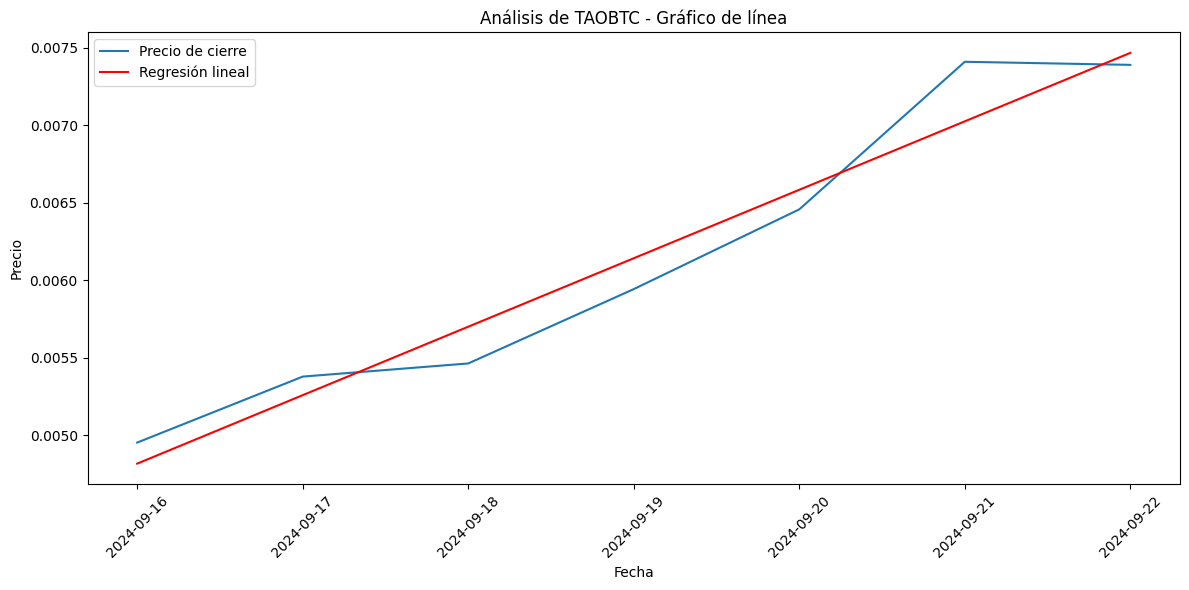

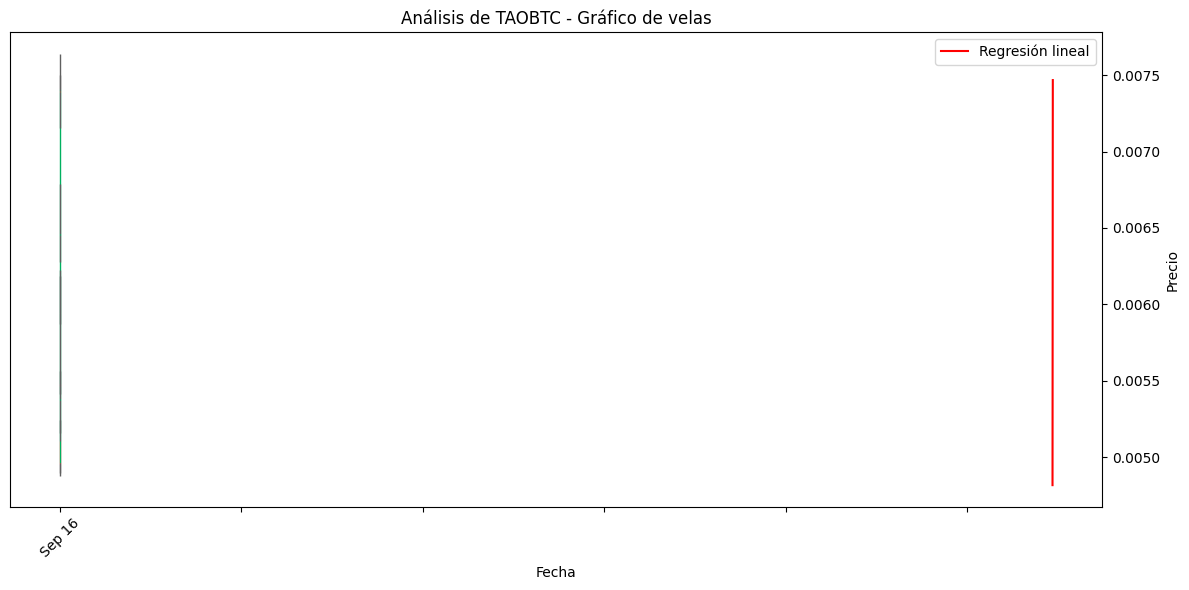

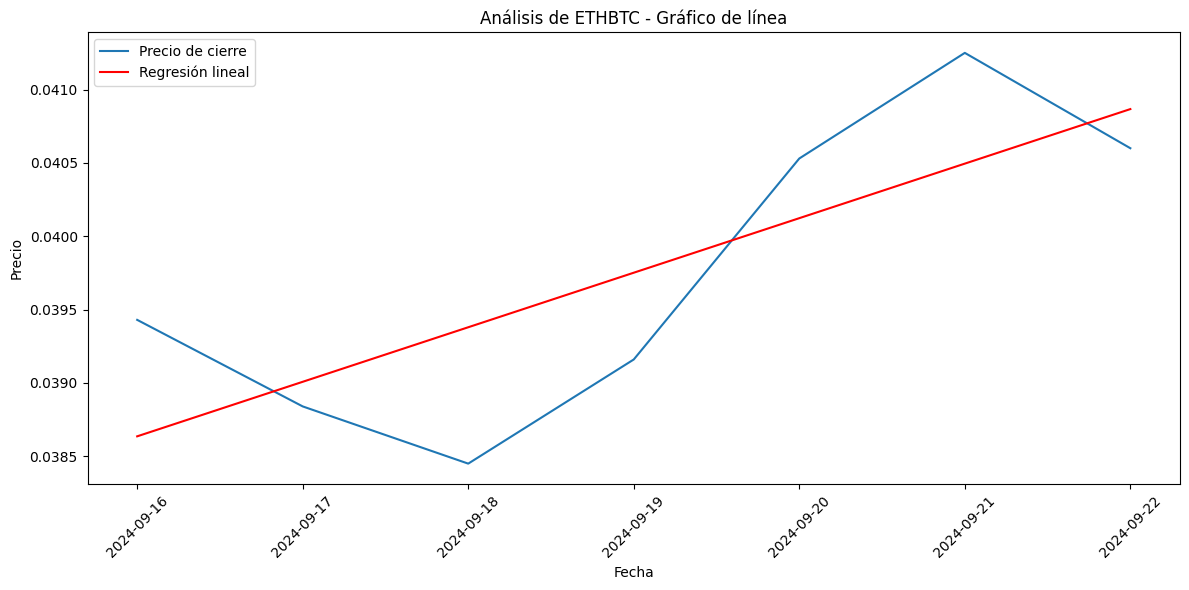

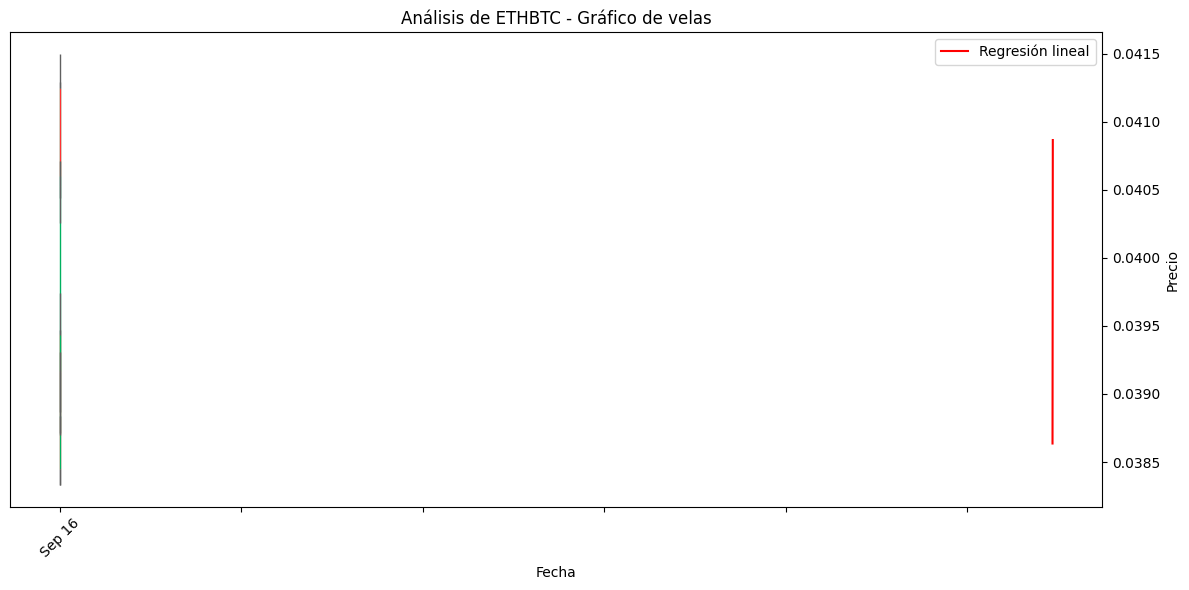

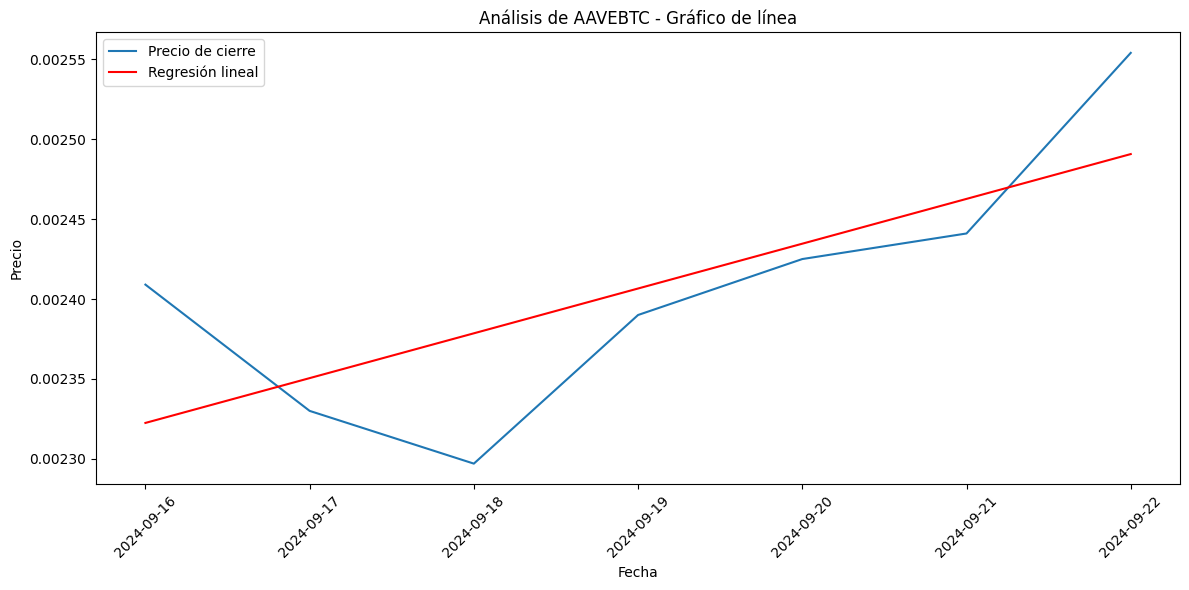

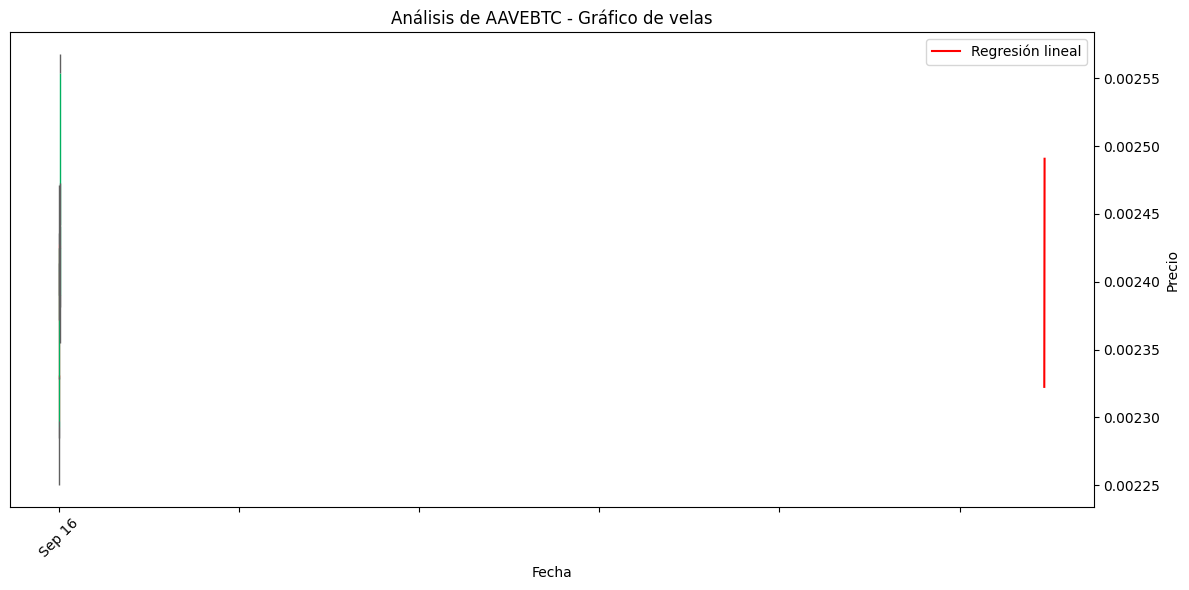

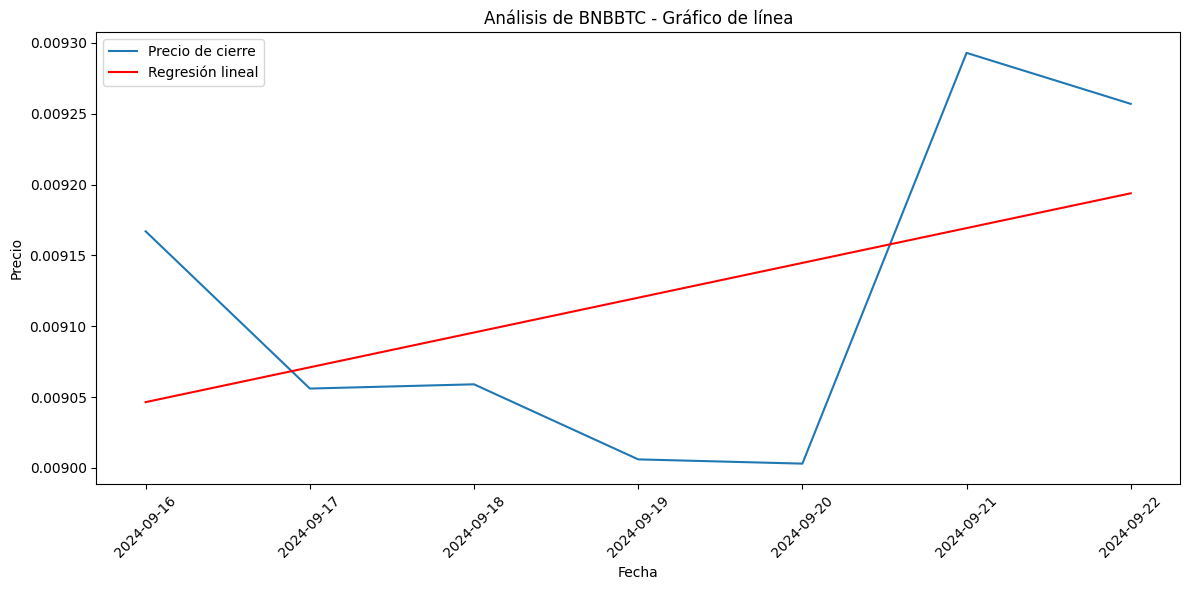

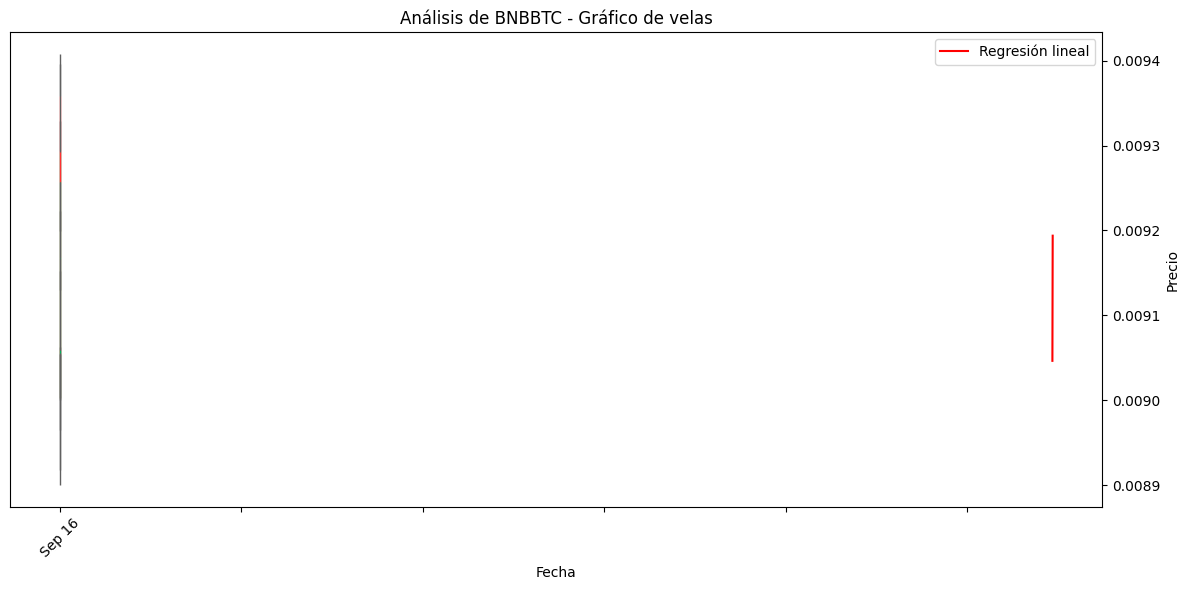

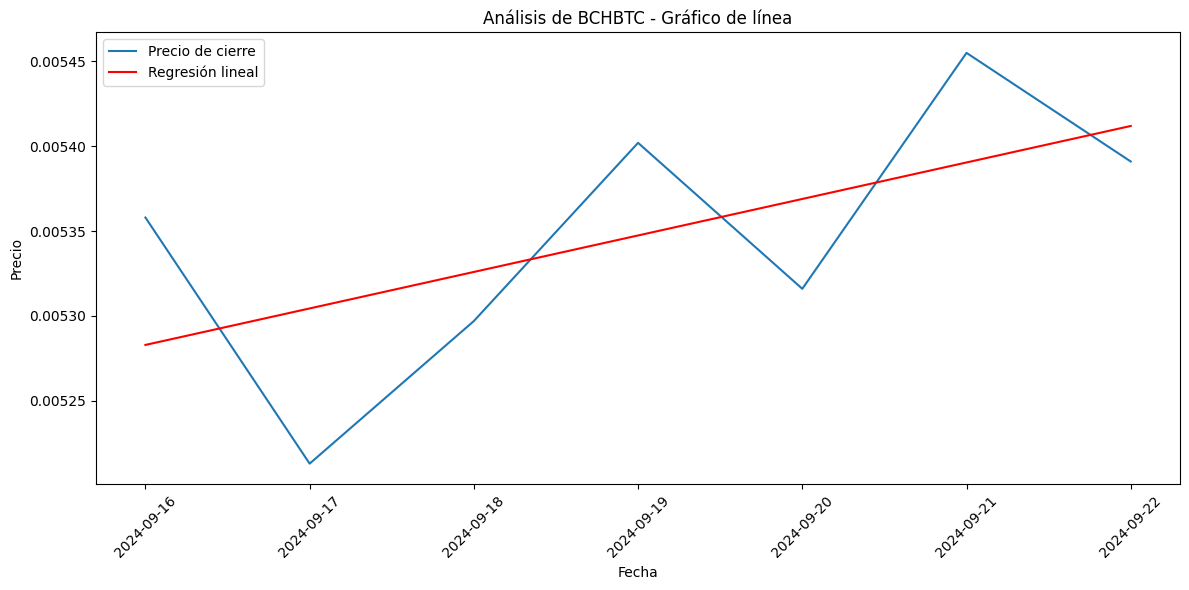

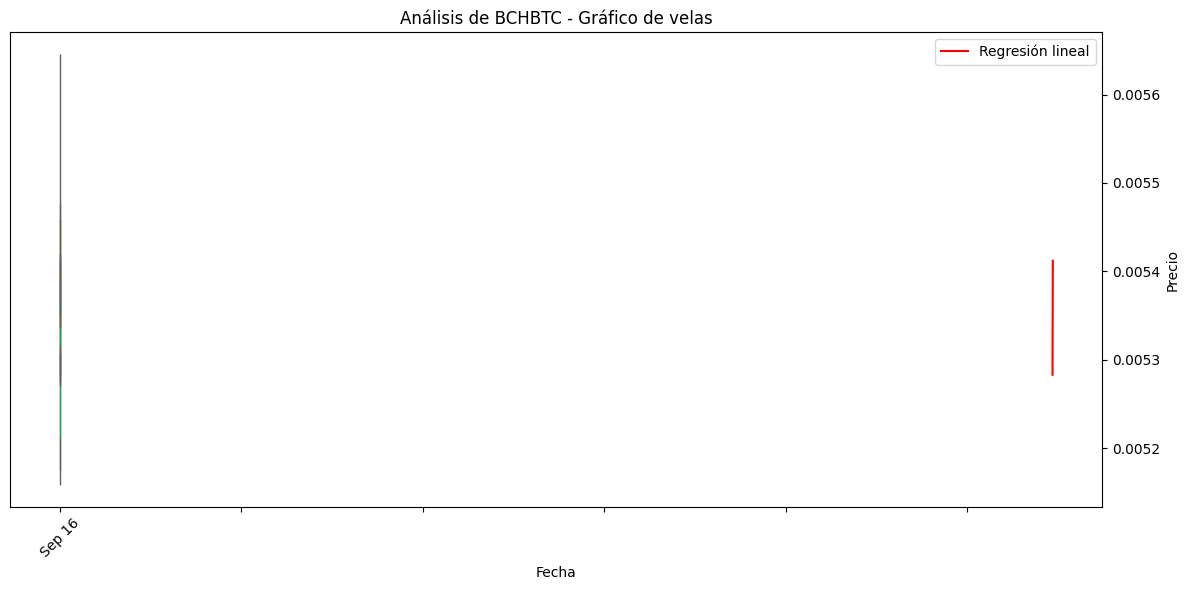

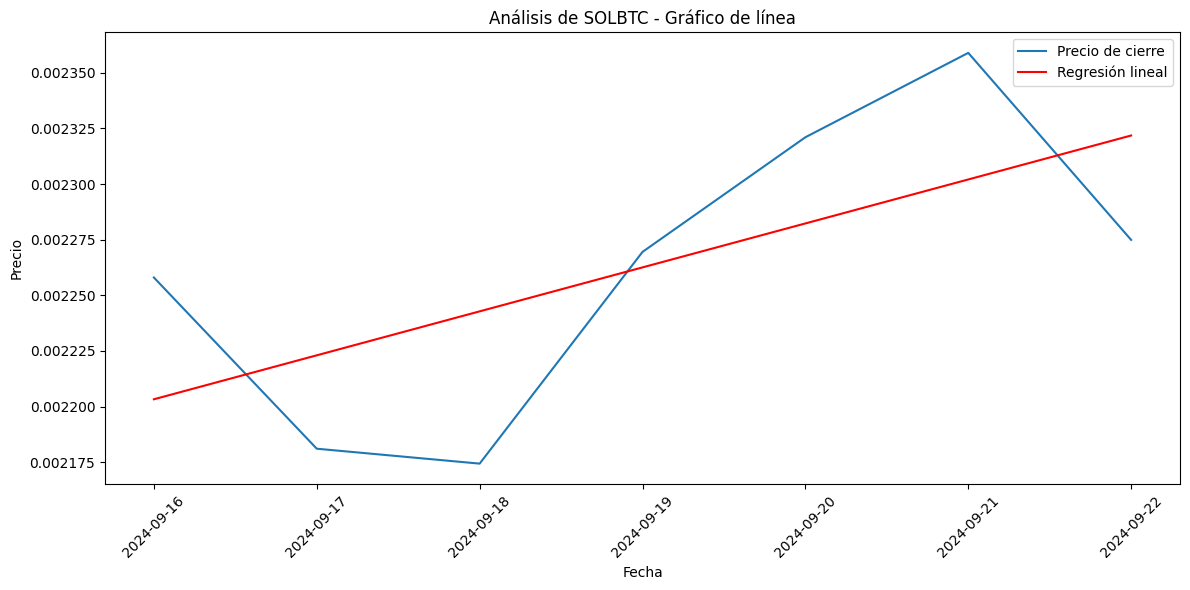

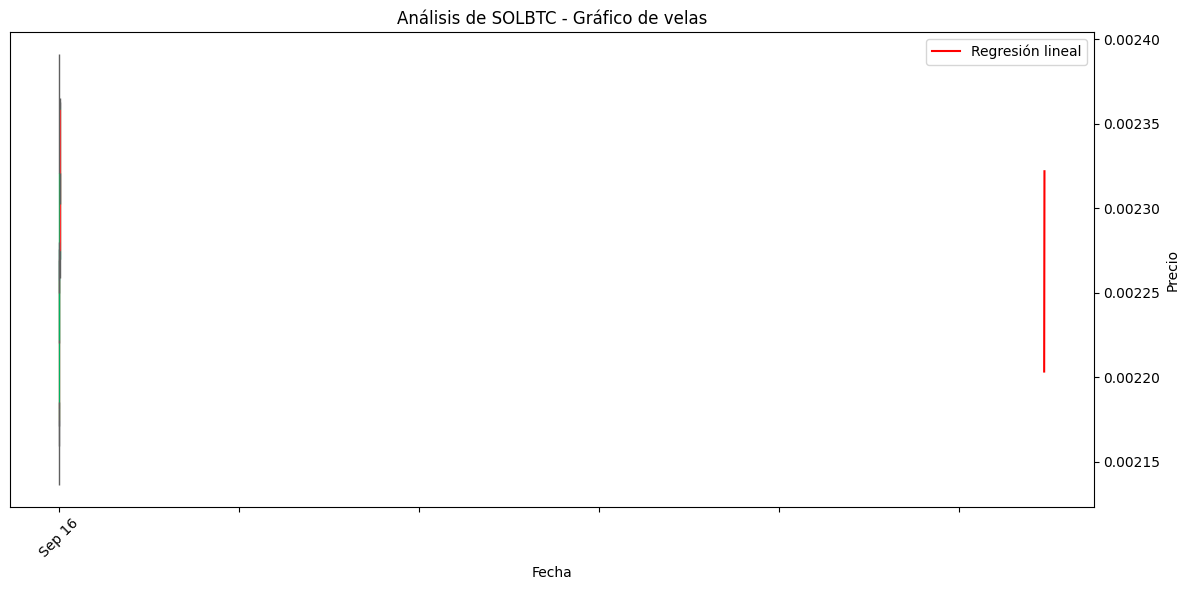

In [49]:
# Ploteo 1, plotea bien el linechart pero no el candlestick

import os
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

def plot_crypto_data(df_maestro, data_folder='data', plot_folder='plots'):
    # Crear la carpeta 'plots' si no existe
    if not os.path.exists(plot_folder):
        os.makedirs(plot_folder)

    #for _, row in df_maestro.iterrows():
    for _, row in df_maestro.head(6).iterrows():
        coin = row['coin']
        slope = row['slope']
        intercept = row['intercept']

        # Leer el archivo CSV correspondiente
        df = pd.read_csv(os.path.join(data_folder, f"{coin}.csv"))
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)

        # Calcular la línea de regresión
        x = range(len(df))
        regression_line = [slope * xi + intercept for xi in x]

        # Gráfico de línea
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['close'], label='Precio de cierre')
        plt.plot(df.index, regression_line, label='Regresión lineal', color='red')
        plt.title(f"Análisis de {coin} - Gráfico de línea")
        plt.xlabel("Fecha")
        plt.ylabel("Precio")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(plot_folder, f"{coin}_line.png"))
        plt.show()

        # Gráfico de velas (candlestick)
        fig, ax = plt.subplots(figsize=(12, 6))
        mpf.plot(df, type='candle', style='yahoo', ax=ax)
        ax.plot(df.index, regression_line, label='Regresión lineal', color='red')
        ax.set_title(f"Análisis de {coin} - Gráfico de velas")
        ax.set_xlabel("Fecha")
        ax.set_ylabel("Precio")
        ax.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(plot_folder, f"{coin}_candlestick.png"))
        plt.show()

# Ejemplo de uso:
#df_maestro = analyze_crypto_data()  # Asumiendo que esta función ya fue definida y ejecutada
plot_crypto_data(df_maestro)

In [47]:
asd = df_maestro.iterrows()
for _, row in df_maestro.head(10).iterrows():
    print (row['coin'])

TAOBTC
ETHBTC
AAVEBTC
BNBBTC
BCHBTC
SOLBTC
TRBBTC
METISBTC
AVAXBTC
ORDIBTC
